# Synergy Data Exploration

This tutorial introduces the Synergy data available through the `synergyplaytypes` endpoint of the (stats.nba.com)[https://stats.nba.com] API. The features available are documented [here](https://github.com/basketballrelativity/py_ball/wiki/Synergy). The goal of this exploration is to identify the best and worst performers across the available Synergy play types.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import synergy, image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `synergyplaytypes` endpoint accepts the following parameters:
- league_id: '00' for the NBA, '10' for the WNBA (Synergy data only seems to be available for the NBA)
- season_year: YYYY-ZZ season year format (This only affects the league averages returned)
- season_type: One of 'Regular Season', 'Pre Season', 'Playoffs', 'All Star'
- per_mode: The type of rate stats to be returned. One of 'Totals', 'PerGame'
- player_or_team: String indicating whether to return data for players ('P') or teams ('T')
- play_type: Type of play as defined by Synergy. Valid values include 'Cut', 'Handoff', 'Isolation', 'Misc', 'OffScreen', 'Postup', 'PRBallHandler', 'PRRollman', 'OffRebound', 'Spotup', 'Transition'
- type_grouping: The side of the ball for the statistics to be returned. One of 'offensive' or 'defensive'

In [2]:
league_id = '00' # NBA
season_year = '2018-19'
season_type = 'Regular Season'
per_mode = 'Totals'
player_or_team = 'P'
play_type = 'PRRollman'
type_grouping = 'offensive'

synergy_data = synergy.Synergy(headers=HEADERS,
                               endpoint='synergyplaytypes',
                               league_id=league_id,
                               season_year=season_year,
                               season_type=season_type,
                               per_mode=per_mode,
                               player_or_team=player_or_team,
                               play_type=play_type,
                               type_grouping=type_grouping)
synergy_df = pd.DataFrame(synergy_data.data['SynergyPlayType'])

In [3]:
synergy_df.iloc[0]

SEASON_ID                     22018
PLAYER_ID                    202696
PLAYER_NAME          Nikola Vucevic
TEAM_ID                  1610612753
TEAM_ABBREVIATION               ORL
TEAM_NAME             Orlando Magic
PLAY_TYPE                 PRRollMan
TYPE_GROUPING             Offensive
PERCENTILE                    0.611
GP                               80
POSS_PCT                      0.205
PPP                           1.127
FG_PCT                        0.542
FT_POSS_PCT                   0.069
TOV_POSS_PCT                  0.073
SF_POSS_PCT                   0.069
PLUSONE_POSS_PCT              0.012
SCORE_POSS_PCT                0.529
EFG_PCT                       0.585
POSS                            331
PTS                             373
FGM                             156
FGA                             288
FGMX                            132
Name: 0, dtype: object

Note the available fields in the above:
- `POSS_PCT`: Percentage of plays for the player of the corresponding play type
- `PPP`: Points per possession
- `xx_POSS_PCT`: Frequency of result `xx`

With the available fields defined, let's identify the best and worst performers by `PPP` in the 2018-19 season, using 100 possessions as a qualifying threshold to ensure we're identifying a population of players that leverage the play type consistently.

In [4]:
pr_roll_df = synergy_df[synergy_df['POSS']>=100].sort_values('PPP', ascending=False)
print('Average PRRollman PPP: ' + str(np.mean(pr_roll_df['PPP'])))
for ind, row in pr_roll_df.head(5).iterrows():
    print(row['PLAYER_NAME'] + ': ' + str(row['PPP']) + ' points per possession (' + str(row['POSS']) + ' possessions)')

Average PRRollman PPP: 1.1466862745098039
Mitchell Robinson: 1.462 points per possession (106 possessions)
Mason Plumlee: 1.404 points per possession (109 possessions)
DeAndre Jordan: 1.353 points per possession (119 possessions)
Rudy Gobert: 1.349 points per possession (272 possessions)
Julius Randle: 1.337 points per possession (101 possessions)


In [5]:
for ind, row in pr_roll_df.tail(5).iterrows():
    print(row['PLAYER_NAME'] + ': ' + str(row['PPP']) + ' points per possession (' + str(row['POSS']) + ' possessions)')

Marc Gasol: 0.996 points per possession (269 possessions)
Cody Zeller: 0.959 points per possession (122 possessions)
Joel Embiid: 0.947 points per possession (132 possessions)
Rondae Hollis-Jefferson: 0.905 points per possession (105 possessions)
Trey Lyles: 0.624 points per possession (109 possessions)


These lists match intutition to some degree. Some slower big men end up near the bottom of the league as rollmen, while some more agile players end up in the top of the league. At this point, moving beyond a list and towards a visualization should lead to easier and more impactful takeaways.

In [6]:
def add_logo(fig, logo, x_frac, y_frac, size=72):
    """ This function adds a logo to the provided figure

    Args:

        @param **fig** (matplotlib.figure.Figure): Figure object of franchise
            history barchart

        @param **logo** (PngImageFile): PNG image object of logo corresponding
            to a basketball franchise

        @param **x_frac** (float): Value corresponding to the horizontal position
            at which the image is to be initiated

        @param **y_frac** (float): Value corresponding to the vertical position
            at which the image is to be initiated

    Returns:

        **fig** (matplotlib.figure.Figure): Figure object of franchise
            history barchart with the corresponding logo added
    """

    logo = logo.convert('RGBA')
    logo.thumbnail((size, size), Image.ANTIALIAS)
    logo = logo.rotate(180)
    logo = logo.transpose(Image.FLIP_LEFT_RIGHT)
    img_x, img_y = logo.size[0], logo.size[1]
    x_offset = int((fig.bbox.xmax * x_frac - img_x/2))
    y_offset = int((fig.bbox.ymax * y_frac - img_y/2))
    #     print(x_offset)
#     print(fig.bbox.ymax)
    fig.figimage(logo, origin={'lower'},
                 xo=x_offset, yo=y_offset, zorder=10)

    return fig

In [7]:
def visualize_synergy(syn_play_type, threshold, ball_side):
    """ visualize_synergy creates a bar chart for the top 5 and
    bottom 5 players in points per possession with the threshold
    number of possessions.

    @param syn_play_type (str): Type of play as defined by Synergy. Valid values include \
        'Cut', 'Handoff', 'Isolation', 'Misc', 'OffScreen', 'Postup', 'PRBallHandler', 
        'PRRollman', 'OffRebound', 'Spotup', 'Transition'
    @param treshold (int): Minimum number of possessions to be eligible for the visualization
    @param ball_side (str): Side of the ball for which the visualization should be generated. \
        One of 'offensive' or defensive.
    """

    synergy_data = synergy.Synergy(headers=HEADERS,
                                   endpoint='synergyplaytypes',
                                   league_id=league_id,
                                   season_year=season_year,
                                   season_type=season_type,
                                   per_mode=per_mode,
                                   player_or_team=player_or_team,
                                   play_type=syn_play_type,
                                   type_grouping=ball_side)

    synergy_df = pd.DataFrame(synergy_data.data['SynergyPlayType'])
    synergy_df = synergy_df[synergy_df['POSS']>=threshold].sort_values('PPP', ascending=False)
    
    if len(synergy_df) >= 10:
        top_ids = list(synergy_df.head(5)['PLAYER_ID'])[::-1]
        top_names = list(synergy_df.head(5)['PLAYER_NAME'])[::-1]
        top_teams = list(synergy_df.head(5)['TEAM_ID'])[::-1]
        top_vals = list(synergy_df.head(5)['PPP'])[::-1]
        bottom_ids = list(synergy_df.tail(5)['PLAYER_ID'])[::-1]
        bottom_names = list(synergy_df.tail(5)['PLAYER_NAME'])[::-1]
        bottom_teams = list(synergy_df.tail(5)['TEAM_ID'])[::-1]
        bottom_vals = list(synergy_df.tail(5)['PPP'])[::-1]
        avg_val = np.mean(synergy_df['PPP'])

        fig = plt.figure(figsize=(14, 8))
        axis = fig.add_axes([0., 0., 1., 1., ])

        plt.plot(bottom_vals + top_vals, range(len(bottom_vals + top_vals)), 'ko')
        axis.axvline(avg_val, c='k', linestyle='--', label=season_year + ' Average ' + syn_play_type + ' PPP')
        labels = ['']*len(bottom_names + top_names)
        plt.xticks(fontsize=14)
        plt.xlabel('Points Per Possession', fontsize=14)
        plt.yticks(range(len(bottom_names + top_names)), labels, fontsize=14)
        plt.xlim(0, 2)

        horiz_frac = 0
        vertical_frac = 1/10.0
        increment = 1/10.0
        count = 0
        for player, team, vals, names in zip(bottom_ids + top_ids,
                                             bottom_teams + top_teams,
                                             bottom_vals + top_vals,
                                             bottom_names + top_names):
            test_shot = image.Headshot(league='NBA',
                                       team_id=str(team),
                                       player_id=str(player),
                                       season=season_year[0:4]).image
            fig = add_logo(fig, test_shot, vals / 2.0, vertical_frac)
            plt.text(vals + 0.01, count, names, fontsize=14)
            vertical_frac += increment
            count += 1

    else:
        print('Opps! There are not 10 qualifying players. Please reduce the threshold')

    plt.legend(loc='upper left', fontsize=14)
    plt.title(season_year + ' Top/Bottom 5 ' + syn_play_type + ' Players by PPP (' + ball_side.title() + ')',
              fontsize=20)
    plt.show()

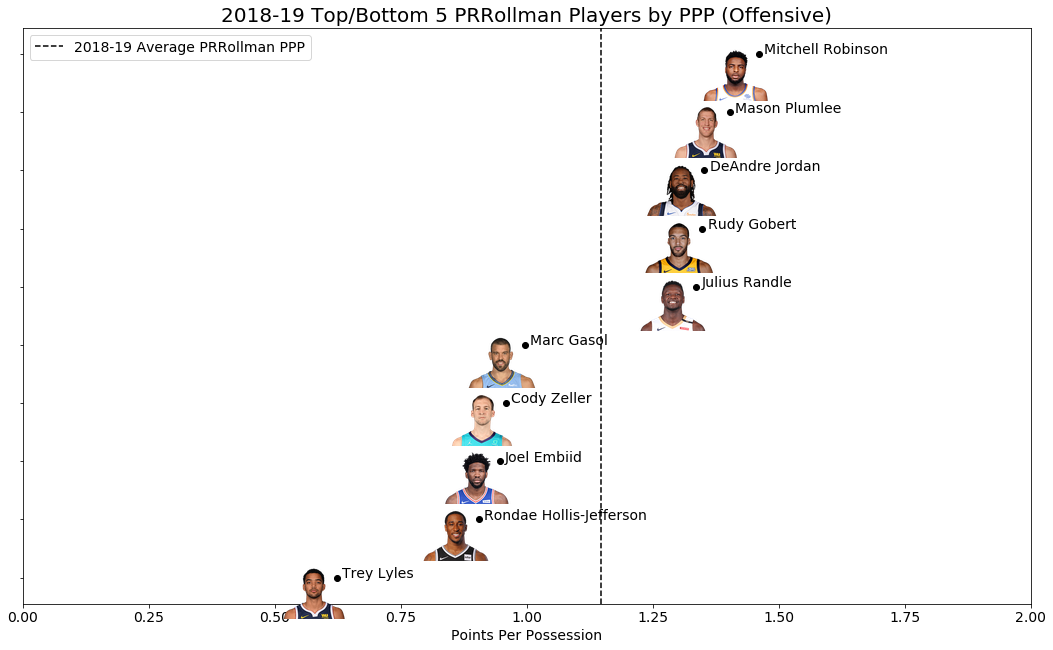

In [8]:
visualize_synergy('PRRollman', 100, 'offensive')

With this function, we can easily explore the other play types and view the top and bottom players.

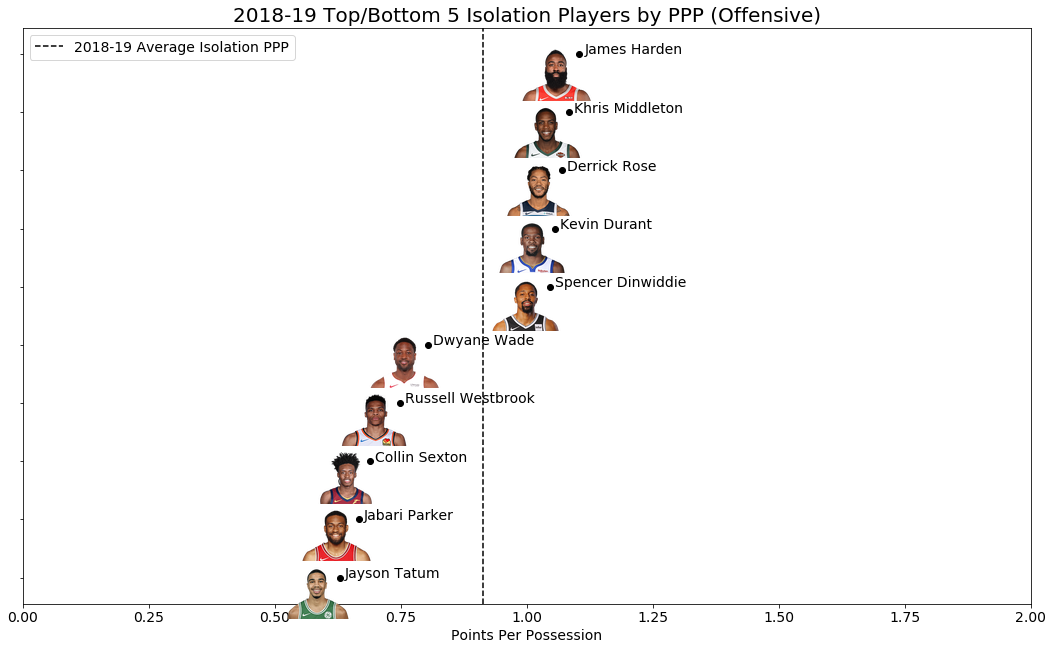

In [9]:
visualize_synergy('Isolation', 100, 'offensive')

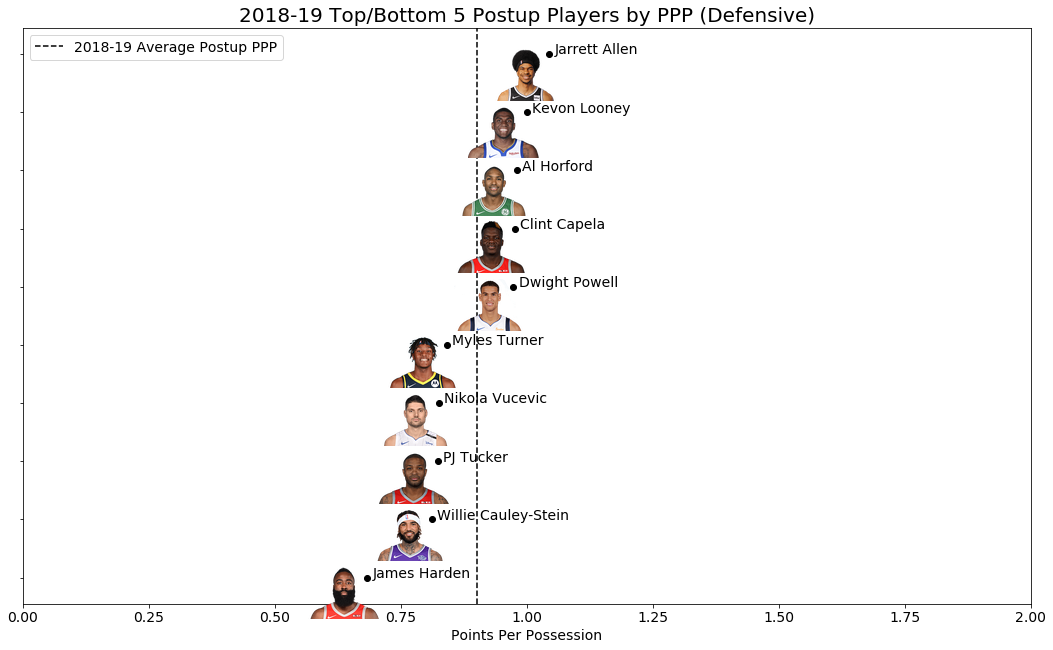

In [10]:
visualize_synergy('Postup', 100, 'defensive')

# Exploration

- Can you brainstorm additional ways to visualize Synergy data?
- Adjust the `visualize_synergy` function to be more flexible. For example, visualizing the top/bottom 5 players is hardcoded into the function. Make this variable a function argument and adjust the function accordingly.
- Write a function to visualize PPP for one player across all play types.